Analyze size/extend of a single gel.

In [1]:
import sys

sys.path.append("../")

In [ ]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from config import Config

In [3]:
def extract_timestep(p: Path) -> int:
    return int(p.stem.split("_")[-1])


def get_bead_file_subset(gel_dir_path: Path, stripe_size: int = 1) -> pd.DataFrame:
    all_pos_files = sorted(
        (gel_dir_path / "raw/gel_eq").glob("*.npy"), key=extract_timestep
    )
    pos_files = all_pos_files[:: max(1, stripe_size)]
    timesteps = [extract_timestep(p) for p in pos_files]
    config = Config.from_file(gel_dir_path / "config.json")
    df = pd.DataFrame({"paths": pos_files, "timestep": timesteps})
    df["forcefield"] = config.agent_force_field
    return df


gel_dir = Path().home() / "data/mmgel/production3/run_0_ff_none_meshw_2.5_charge_0.05"

In [4]:
config = Config.from_file(gel_dir / "config.json")
BOX_L = config.initial_box_l
R = config.constraint_radius

In [ ]:
bead_df = get_bead_file_subset(gel_dir)
bead_df

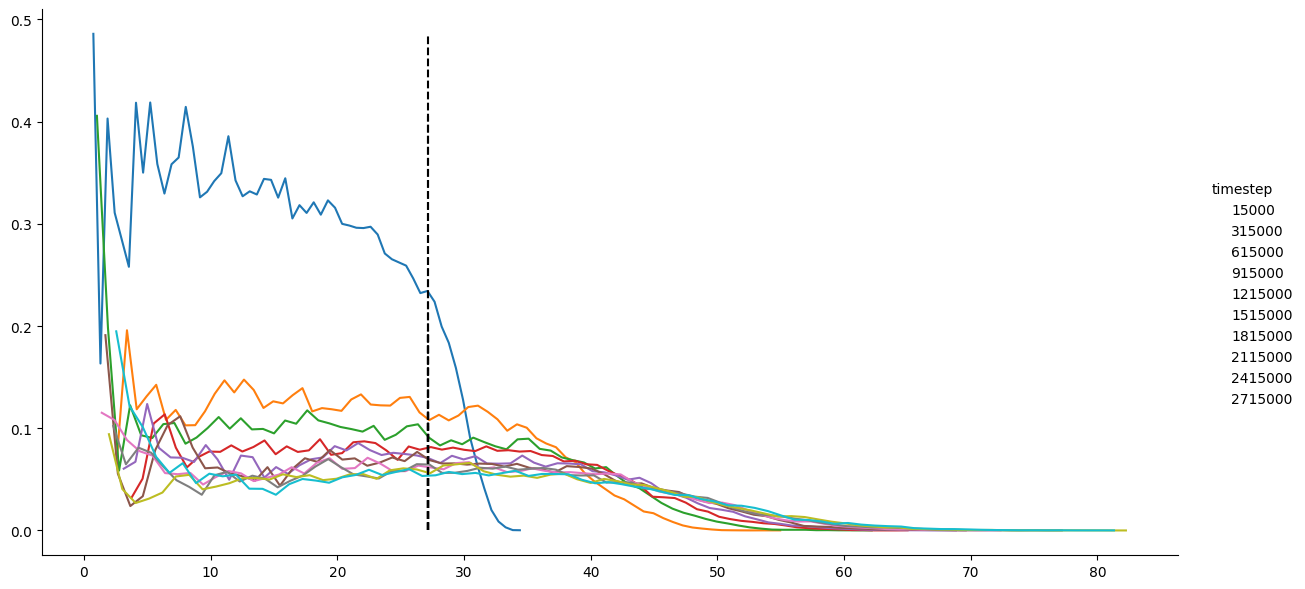

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_density(df):
    g = sns.FacetGrid(df[::20], hue="timestep")
    g.figure.set_size_inches(12, 6)

    def density_lines(data, color, **kwargs):
        pos = np.load(data["paths"].iloc[0])
        ax = plt.gca()
        distance_from_center = np.linalg.norm(pos - BOX_L / 2, axis=-1)
        density, bin_edges = np.histogram(distance_from_center, bins="auto")

        bin_volumes = 4.0 / 3.0 * np.pi * (bin_edges[1:] ** 3 - bin_edges[:-1] ** 3)
        density = density / bin_volumes
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

        ax.plot(bin_centers, density, color=color, label=data["forcefield"].iloc[0])
        ax.vlines(
            config.constraint_radius,
            density.min(),
            density.max(),
            color="black",
            linestyles="--",
        )

    g.map_dataframe(density_lines)
    g.add_legend()
    plt.show()


plot_density(bead_df)

In [7]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np


# def plot_density(df):
#     g = sns.FacetGrid(
#         df, col="timestep", col_wrap=4, hue="forcefield", sharex=True, sharey=True
#     )

#     def density_lines(data, color, **kwargs):
#         agent_pos = np.load(data["paths"].iloc[0])
#         ax = plt.gca()
#         distance_from_center = np.linalg.norm(agent_pos - BOX_L / 2, axis=-1)
#         density, bin_edges = np.histogram(distance_from_center, bins="auto")

#         bin_volumes = 4.0 / 3.0 * np.pi * (bin_edges[1:] ** 3 - bin_edges[:-1] ** 3)
#         density = density / bin_volumes
#         bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

#         ax.plot(bin_centers, density, color=color, label=data["forcefield"].iloc[0])
#         ax.vlines(
#             config.constraint_radius,
#             density.min(),
#             density.max(),
#             color="black",
#             linestyles="--",
#         )

#     g.map_dataframe(density_lines)
#     g.add_legend()
#     plt.show()


# plot_density(bead_df)

# Hydrodynamic radius over time

In [ ]:
from time import time
from analysis.analyze import HydroRadiusComputer


def measure_time():
    times_gnu = []
    times_triv = []
    ns = [2**i for i in range(3, 7)]
    for n in ns:
        files = bead_df["paths"].iloc[:n].tolist()
        dt = time()
        np.array([HydroRadiusComputer.process_file(p) for p in files])
        dt = time() - dt
        times_triv.append(dt)

        dt = time()
        HydroRadiusComputer.process_files(files)
        dt = time() - dt
        times_gnu.append(dt)

    return pd.DataFrame(
        {"n": ns, "Duration gnu [s]": times_gnu, "Duration triv [s]": times_triv}
    )

In [9]:
# time_df = measure_time()

In [10]:
# time_df.plot(x="n", marker="o")
# plt.gca().set_xscale("log")
# plt.gca().set_yscale("log")

In [ ]:
MAX_NUM_DATA_POINTS = 10
paths_to_process = bead_df["paths"].iloc[::max(len(bead_df) // MAX_NUM_DATA_POINTS, 1)]
hydro_df = HydroRadiusComputer.process_files(paths_to_process)

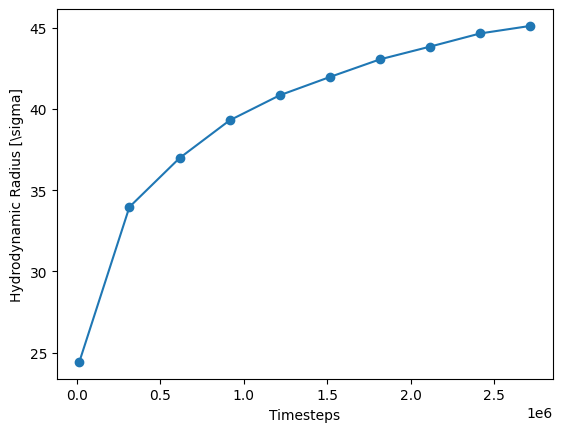

In [12]:
hydro_df = hydro_df.sort_values(by="timestep")

fig, ax = plt.subplots()
ax.plot(hydro_df["timestep"], hydro_df["hydro_radius"], "-o")
ax.set_xlabel("Timesteps")
ax.set_ylabel("Hydrodynamic Radius [\sigma]")

plt.show()

In [13]:
# !pip install statsmodels

In [14]:
# from statsmodels.nonparametric.kernel_regression import KernelReg

# x = hydro_df["timestep"]
# y = hydro_df["hydro_radius"]

# # The third parameter specifies the type of the variable x;
# # 'c' stands for continuous
# kr = KernelReg(y, x, "c")
# y_pred, y_std = kr.fit(x)

In [15]:
# fig, ax = plt.subplots()

# ax.plot(x, y, "-", marker=".", label="Data")
# ax.plot(x, y_pred, label="Smoothed Data")
# ax.set_xlabel("Timesteps")
# ax.set_ylabel("Hydrodynamic Radius [\sigma]")

# plt.legend()
# plt.show()